In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.impute import SimpleImputer

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen,DetectChemistryProblems, PandasTools

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

In [2]:
def get_desc(mol):
    desc_dict = {}
    for desc_name, desc_calc in Descriptors._descList:
        try:
            desc_value = desc_calc(mol)
        except:
            desc_value = None
        desc_dict[desc_name] = desc_value
    
    return desc_dict            

In [3]:
df = pd.read_csv('EGFR_Chembl_clean.csv')
df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,pIC50,Standardized Smiles,Molecule
0,CHEMBL271410,NaN,NaN,378.48,0.0,3.21,"126, page S27 table 1",Cc1cccc(Nc2ncnc3ccncc23)c1NCCCN1CCOCC1,IC50,'=',...,1,Scientific Literature,J Med Chem,2008.0,NaN,NaN,NaN,8.03,Cc1cccc(Nc2ncnc3ccncc23)c1NCCCN1CCOCC1,<rdkit.Chem.rdchem.Mol object at 0x000001B30B8...
1,CHEMBL411243,NaN,NaN,429.37,0.0,4.67,"109, page S26 table 1",CN(C)CCCCCNc1c(Br)cccc1Nc1ncnc2ccncc12,IC50,'=',...,1,Scientific Literature,J Med Chem,2008.0,NaN,NaN,NaN,8.07,CN(C)CCCCCNc1c(Br)cccc1Nc1ncnc2ccncc12,<rdkit.Chem.rdchem.Mol object at 0x000001B30B8...
2,CHEMBL270713,NaN,NaN,387.29,0.0,3.50,"106, page S26 table 1",CN(C)CCNc1c(Br)cccc1Nc1ncnc2ccncc12,IC50,'=',...,1,Scientific Literature,J Med Chem,2008.0,NaN,NaN,NaN,7.34,CN(C)CCNc1c(Br)cccc1Nc1ncnc2ccncc12,<rdkit.Chem.rdchem.Mol object at 0x000001B30B8...
3,CHEMBL54475,NaN,NaN,301.15,0.0,3.53,"78, page S25 table 1",Brc1cccc(Nc2ncnc3ncccc23)c1,IC50,'=',...,1,Scientific Literature,J Med Chem,2008.0,NaN,NaN,NaN,6.16,Brc1cccc(Nc2ncnc3ncccc23)c1,<rdkit.Chem.rdchem.Mol object at 0x000001B30B8...
4,CHEMBL405772,NaN,NaN,251.29,0.0,2.66,"72, page S25 table 1",Cc1cccc(Nc2ncnc3ccncc23)c1N,IC50,'=',...,1,Scientific Literature,J Med Chem,2008.0,NaN,NaN,NaN,7.39,Cc1cccc(Nc2ncnc3ccncc23)c1N,<rdkit.Chem.rdchem.Mol object at 0x000001B30B8...


In [4]:
df = df[['Molecule ChEMBL ID','Standardized Smiles','pIC50']]
PandasTools.AddMoleculeColumnToFrame(df,'Standardized Smiles', 'Molecule', includeFingerprints = False)

,Molecule ChEMBL ID,Standardized Smiles,pIC50,Molecule,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CHEMBL271410,Cc1cccc(Nc2ncnc3ccncc23)c1NCCCN1CCOCC1,8.03,,5.413531,0.763951,5.413531,0.763951,0.611539,378.480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CHEMBL411243,CN(C)CCCCCNc1c(Br)cccc1Nc1ncnc2ccncc12,8.07,,4.400272,0.750216,4.400272,0.750216,0.482053,429.366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2,CHEMBL270713,CN(C)CCNc1c(Br)cccc1Nc1ncnc2ccncc12,7.34,,4.367924,0.737833,4.367924,0.737833,0.675069,387.285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CHEMBL54475,Brc1cccc(Nc2ncnc3ncccc23)c1,6.16,,4.254307,0.685182,4.254307,0.685182,0.786423,301.147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CHEMBL405772,Cc1cccc(Nc2ncnc3ccncc23)c1N,7.39,,6.052971,0.704074,6.052971,0.704074,0.684596,251.293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

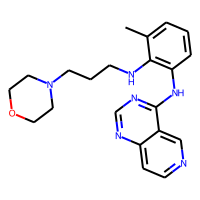
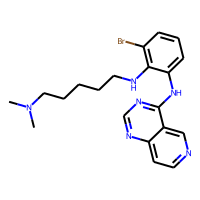
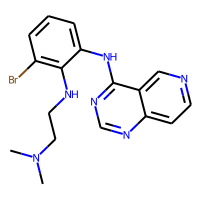
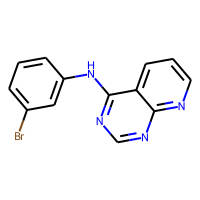
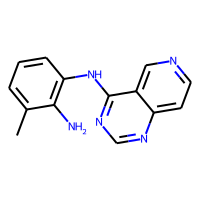

In [5]:
for i in range(df.shape[0]):
    mol = df.loc[i,'Molecule']
    desc_dict = get_desc(mol)
    df.loc[i,list(desc_dict.keys())] = desc_dict.values()
    
df.head()

In [6]:
list(df.columns[4:])

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_

In [7]:
df.shape

(5788, 212)

In [8]:
df.dropna(axis = 'columns', how = 'all', inplace = True)
desc_array = df.iloc[:,4:].values

if np.isnan(desc_array).any():
    imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    imp = imp.fit(desc_array)
    desc_array = imp.transform(desc_array)
desc_array.shape

(5788, 207)

In [9]:
sc = StandardScaler()
std_array = sc.fit_transform(desc_array)

pca = PCA(n_components = 0.85) #Get components to explain 85% of the explained variance
array_pca = pca.fit_transform(std_array)
var = pca.explained_variance_ratio_
len(var)

48

<function matplotlib.pyplot.show(close=None, block=None)>

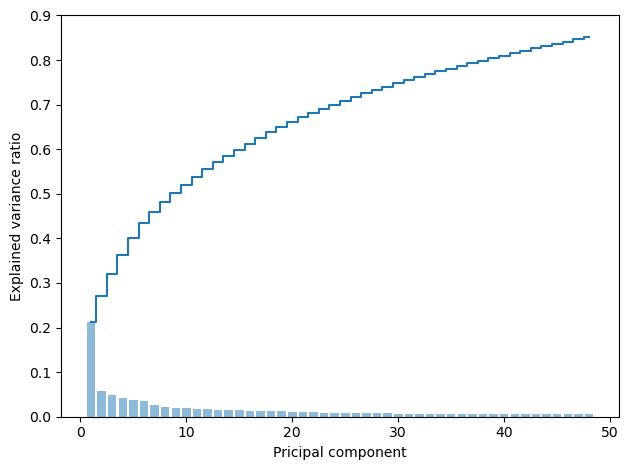

In [10]:
cum_var = np.cumsum(var)

plt.bar(range(1,49), var, alpha = 0.5, align = 'center', label = 'Explained variance by singular value')
plt.step(range(1,49), cum_var, where = 'mid', label = 'Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Pricipal component')
plt.ylim(0.0,0.90)
plt.tight_layout()
plt.show

In [11]:
pca_df = pd.DataFrame(data = array_pca, index = df.index)
pca_df.columns = [f'PCA_{x + 1}' for x in pca_df.columns]
pca_df[['Molecule ChEMBL ID','Standardized Smiles','pIC50']] = df[['Molecule ChEMBL ID','Standardized Smiles','pIC50']]

In [12]:
pca_df.to_csv('egfr_pca.csv', index = False)

Perform k-means clustering